In [52]:
#modulos para red
from tensorflow.keras.layers import Dense, ReLU, Input, Activation, BatchNormalization, MaxPooling2D, Cropping2D, UpSampling2D, Concatenate,Flatten, Conv2D, Conv2DTranspose, LeakyReLU,PReLU, add, ReLU, concatenate
from tensorflow.keras.layers import Flatten, Reshape, Add, GroupNormalization


from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import tensorflow as tf
import keras

#visualización de imagenes
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

import timeit
from functools import wraps
import pickle

## Utils

In [2]:
def randomsamling(N=28,cr=0.1):
  '''
  cr = compression ratio
  N  = full element number
  '''

  x0 = np.ones((N,))
  ss = np.random.permutation(list(range(1, N - 1)))
  x0[ss[0:int(cr * N)]] = 0

  return x0

In [3]:
def subsampling(x,cr=[0.7]):
  '''
  x : full data
  H : random vector 1xN zeros-ones from binomial distribution
  '''
  batch,M,N,L = x.shape

  out = []
  train = []

  for j in cr:
    new = np.zeros_like(x)

    for i in range(batch):
       H = randomsamling(N=N,cr=j)
       new[i,:,:,0] = (x[i,:,:,0]+ (0.5+j)*np.random.normal(0, 0.008, size=(28,28))) * np.tile(H.reshape(1,-1),(x.shape[1],1))
    out.append(new)
    train.append(x)

  return np.concatenate(out,axis=0),np.concatenate(train,axis=0)

In [4]:
def log10(x):
  numerator = K.log(x)
  denominator = K.log(K.constant(10, dtype=numerator.dtype))
  return numerator / denominator

def PSNR(y_true, y_pred):
  msel = tf.keras.losses.MeanSquaredError()
  max_pixel=1
  return 10.0 * log10((max_pixel) / msel(y_true,y_pred))

### Load reconstruction networks (baseline and proposed)

In [22]:
baseline_recovery= keras.models.load_model('models/baseline.h5')
proposed_recovery = keras.models.load_model('models/doubleGAN_model.h5')

### Resnet

# EXP 1 - Field Dataset / Stratton

In [6]:
from skimage.transform import rescale, resize, downscale_local_mean

def rescal3d(cube,size=(64,64)):
    new = np.zeros((size[0],size[1],cube.shape[-1]))
    for i in range(new.shape[-1]):
        new[:,:,i] = resize(cube[:,:,i], size,
                           anti_aliasing=True)
    return new

the shape is:  (700, 100)


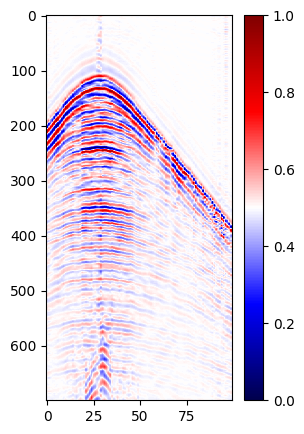

In [9]:
Data =np.load('datasets/exp1/strattonffid.npy')

Data = (Data - np.min(Data))/(np.max(Data) - np.min(Data))
#Data +=1 
#Data /=2

plt.figure(figsize=(3,5))
plt.imshow(Data,aspect='auto',cmap='seismic')
plt.colorbar()

print('the shape is: ', Data.shape)

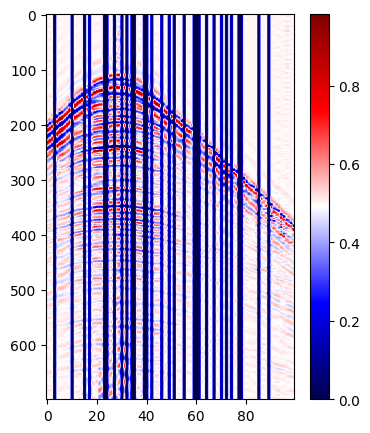

In [18]:
singleffid = Data.copy()
#index from random sampling, here are the values for a single realization for reproducility
# those indices are used to generate Figure 6b
indxx = np.array([60, 40, 51, 67, 10, 72, 77, 23, 61, 17, 55, 74, 46, 64, 85, 32, 24,
       39,  3, 27, 34, 70, 30, 89, 35, 49, 42, 78, 15, 59])

singleffid[:,indxx]=0

plt.figure(figsize=(4,5))
plt.imshow(singleffid,aspect='auto',cmap='seismic')
plt.colorbar()

In [19]:
#!pip install sporco
from sporco import array,plot,util

In [20]:
blksz= (28,28)
stpsz= (1,1)
blcks_corrupt = array.extract_blocks(singleffid, blksz, stpsz)
blcks_non_corrupt = array.extract_blocks(Data, blksz, stpsz)

In [21]:
# bloques en arreglo para ingresar a la red
subblcks_corrupt = blcks_corrupt.transpose(2,0,1)[:,:,:,np.newaxis]
subblcks_non_corrupt = blcks_non_corrupt.transpose(2,0,1)[:,:,:,np.newaxis]

In [23]:
#seismic recovery using a baseline pretrained model.
recov_blcks_baseline = baseline_recovery.predict(subblcks_corrupt)

2024-03-26 11:28:18.995510: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2024-03-26 11:28:19.637038: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-03-26 11:28:19.637060: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2024-03-26 11:28:19.637154: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:317] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-03-26 11:28:19.674003: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1536/1536 [==============================] - 5s 2ms/step


In [51]:
#seismic recovery using  the proposed reconstruction pre-trained network

recov_blcks_proposed = proposed_recovery.predict(subblcks_corrupt)

1536/1536 [==============================] - 3s 2ms/step


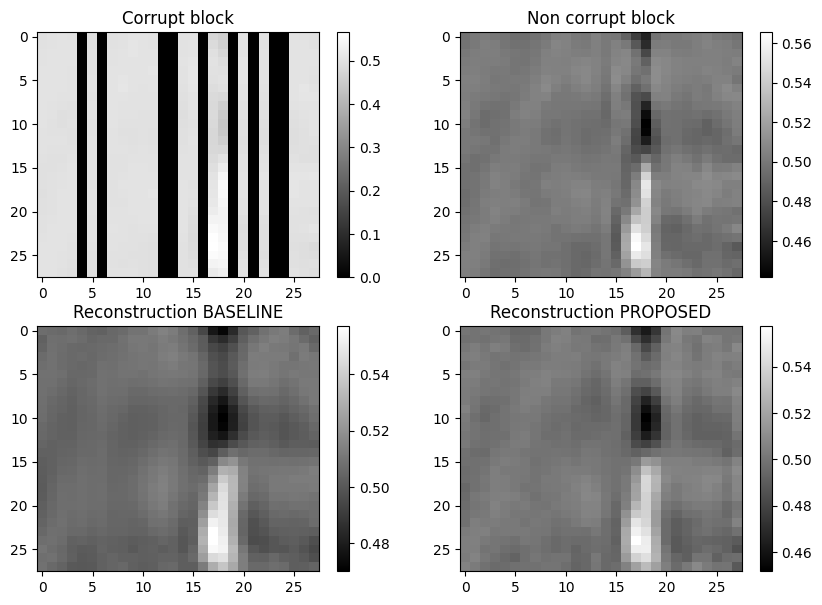

In [35]:
kk = 960
plt.figure(figsize=(10,7))
plt.subplot(221)
plt.imshow(subblcks_corrupt[kk,:,:,0],aspect='auto',cmap='gray'), plt.colorbar()
plt.title("Corrupt block")

plt.subplot(222)
plt.imshow(subblcks_non_corrupt[kk,:,:,0],aspect='auto',cmap='gray'), plt.colorbar()
plt.title("Non corrupt block")

plt.subplot(223)
plt.imshow(recov_blcks_baseline[kk,:,:,0],aspect='auto',cmap='gray'), plt.colorbar()
plt.title("Reconstruction BASELINE")

plt.subplot(224)
plt.imshow(recov_blcks_proposed[kk,:,:,0],aspect='auto',cmap='gray'), plt.colorbar()
plt.title("Reconstruction PROPOSED")

#plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()


In [45]:
#recombine blocks / baseline models

Urec_baseline  = recov_blcks_baseline.squeeze().transpose(1,2,0)
Urec_baseline = Urec_baseline.reshape(np.product(blksz), -1)

#imgd_mean = array.average_blocks(Urec.reshape(blksz + (-1,)), singleffid.shape, stpsz)
imgd_median_baseline = array.combine_blocks(Urec_baseline.reshape(blksz + (-1,)), singleffid.shape, stpsz, np.median)

In [53]:
#recombine blocks / proposed gan models

Urec_proposed  = recov_blcks_proposed.squeeze().transpose(1,2,0)
Urec_proposed = Urec_proposed.reshape(np.product(blksz), -1)

#imgd_mean = array.average_blocks(Urec.reshape(blksz + (-1,)), singleffid.shape, stpsz)
imgd_median_proposed = array.combine_blocks(Urec_proposed.reshape(blksz + (-1,)), singleffid.shape, stpsz, np.median)

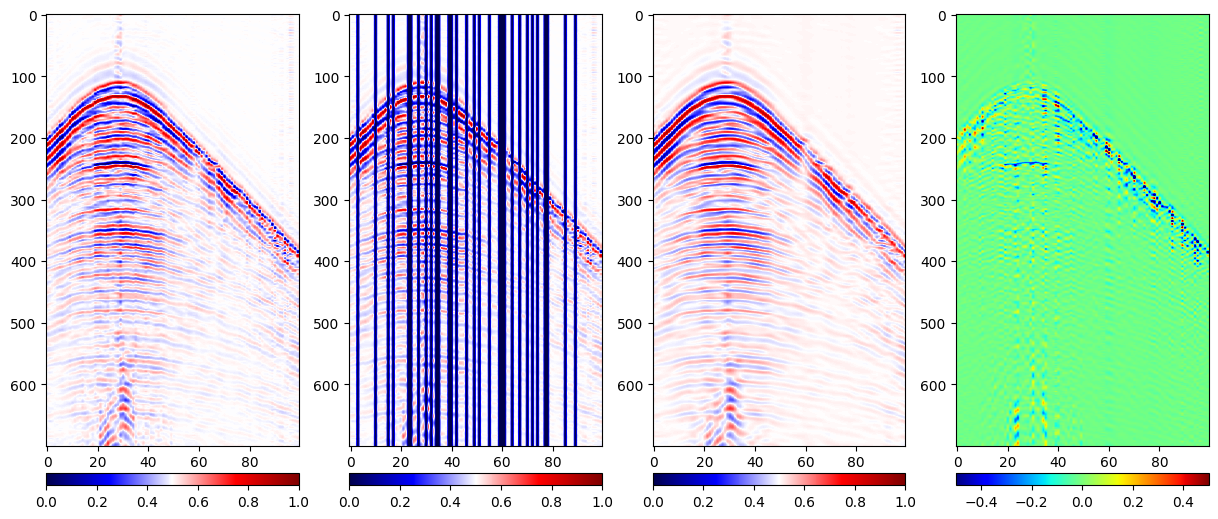

In [58]:
plt.figure(figsize=(15,7))

err = Data-imgd_median_baseline
err /= np.max(np.abs(err))

plt.subplot(141)
plt.imshow(Data,aspect='auto',cmap='seismic')
plt.clim([0,1]),plt.colorbar(orientation='horizontal',pad=0.05)
plt.subplot(142)
plt.imshow(singleffid,aspect='auto',cmap='seismic')
plt.clim([0,1]),plt.colorbar(orientation='horizontal',pad=0.05)
plt.subplot(143)
plt.imshow(imgd_median_baseline,aspect='auto',cmap='seismic'), plt.clim([0,1])
plt.colorbar(orientation='horizontal',pad=0.05)
plt.subplot(144)
plt.imshow(err,aspect='auto',cmap='jet')
plt.clim([-.5,.5])
plt.colorbar(orientation='horizontal',pad=0.05)
plt.show()

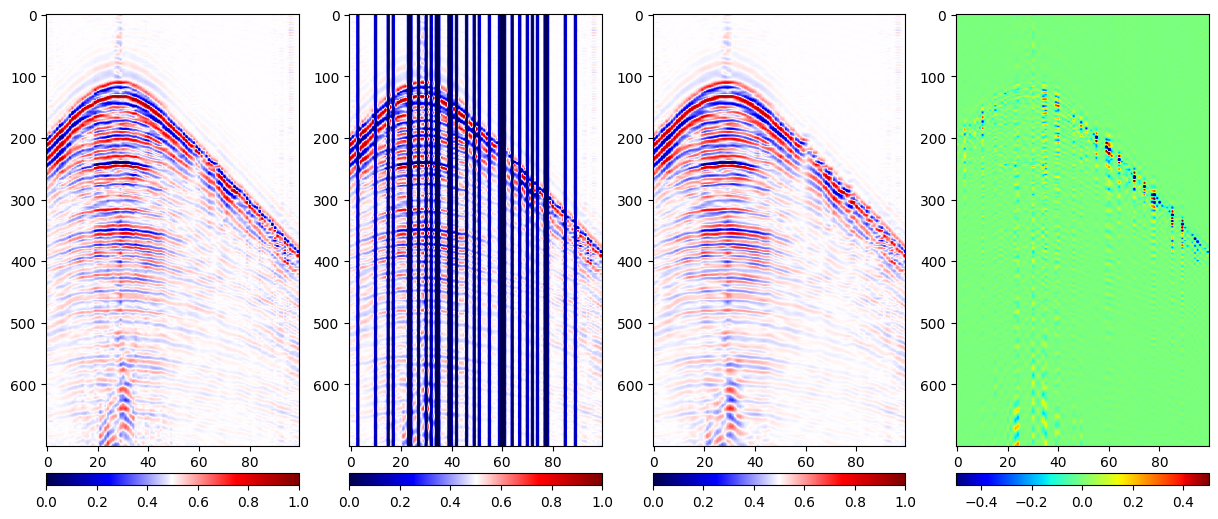

In [60]:
plt.figure(figsize=(15,7))

err2 = Data-imgd_median_proposed
err2 /= np.max(np.abs(err2))

plt.subplot(141)
plt.imshow(Data,aspect='auto',cmap='seismic')
plt.clim([0,1]),plt.colorbar(orientation='horizontal',pad=0.05)
plt.subplot(142)
plt.imshow(singleffid,aspect='auto',cmap='seismic')
plt.clim([0,1]),plt.colorbar(orientation='horizontal',pad=0.05)
plt.subplot(143)
plt.imshow(imgd_median_proposed,aspect='auto',cmap='seismic'), plt.clim([0,1])
plt.colorbar(orientation='horizontal',pad=0.05)
plt.subplot(144)
plt.imshow(err2,aspect='auto',cmap='jet')
plt.clim([-.5,.5])
plt.colorbar(orientation='horizontal',pad=0.05)
plt.show()

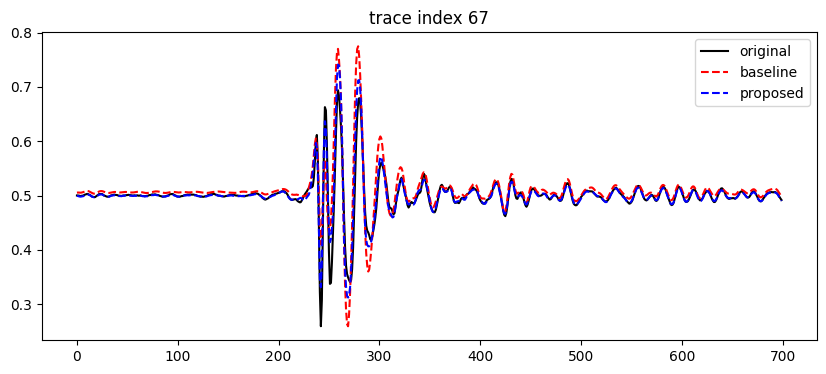

In [67]:
k = 3

plt.figure(figsize=(10,4))
plt.title(f'trace index {indxx[k]}')
plt.plot(Data[:,indxx[k]],'k',label='original')
plt.plot(imgd_median_baseline[:,indxx[k]],'--r',label='baseline')
plt.plot(imgd_median_proposed[:,indxx[k]],'--b',label='proposed')
plt.legend()

In [77]:
from skimage.metrics import structural_similarity as sssim
from skimage.metrics import peak_signal_noise_ratio as ppsnr
from skimage.metrics import mean_squared_error as mse


print("BASELINE ssim:", round(sssim(Data, imgd_median_baseline,data_range=1),3))
print("BASELINE psnr:", round(ppsnr(Data, imgd_median_baseline,data_range=1),3))

print("PROPOSED ssim:", round(sssim(Data,imgd_median_proposed,data_range=1),3))
print("PROPOSED psnr:", round(ppsnr(Data, imgd_median_proposed,data_range=1),3))

BASELINE ssim: 0.956
BASELINE psnr: 32.302
PROPOSED ssim: 0.968
PROPOSED psnr: 33.681


In [82]:
print(f' Mean Squared error (BASELINE) {mse(Data.ravel(),imgd_median_baseline.ravel()):.5f}')
print(f' Mean Squared error (PROPOSED) {mse(Data.ravel(),imgd_median_proposed.ravel()):.5f}')

 Mean Squared error (BASELINE) 0.00059
 Mean Squared error (PROPOSED) 0.00043
